In [335]:
import cv2
import numpy as np
import imutils
from utils.cttutils import displayImage
from scipy.spatial import distance as dist
from imutils import perspective
from imutils import contours
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

## Read test image

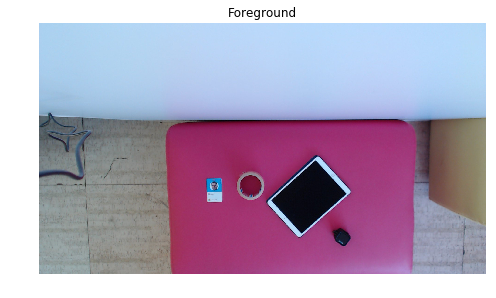

In [336]:
image = cv2.imread("images/ctt1_fg.jpg")
image = imutils.rotate(image,180)
displayImage(image,title='Foreground')

## Read background image

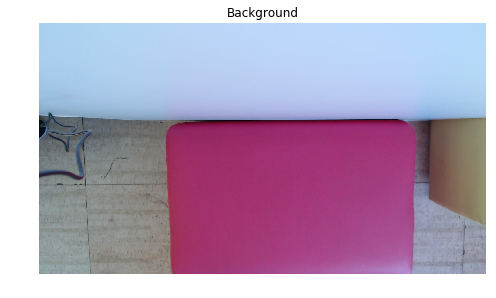

In [337]:
background = cv2.imread("images/ctt1_bg.jpg")
background = imutils.rotate(background,180)
displayImage(background,title='Background')

## Define Cropping limits

In [338]:
#parameters
startX = 600
startY = 450
width = 1000
height = 1080

cropped = image

def cropImage(image, startX, startY, width, height):
    return image[startY:startY+height, startX:startX+width]

def cropLimits(startX,startY, width, height):
    cropped = cropImage(image, startX, startY, width, height)
    displayImage(cropped)
    return startX, startY, width, height
    
w = interactive(cropLimits, startX=widgets.IntSlider(min=0,max=1000,step=10,value=startX, continuous_update=False),
         width=widgets.IntSlider(min=0,max=1920,step=10,value=width, continuous_update=False),
         startY=widgets.IntSlider(min=0,max=1000,step=10,value=startY, continuous_update=False),
         height=widgets.IntSlider(min=0,max=1080,step=10,value=height, continuous_update=False))

display(w)

interactive(children=(IntSlider(value=600, continuous_update=False, description='startX', max=1000, step=10), IntSlider(value=450, continuous_update=False, description='startY', max=1000, step=10), IntSlider(value=1000, continuous_update=False, description='width', max=1920, step=10), IntSlider(value=1080, continuous_update=False, description='height', max=1080, step=10), Output()), _dom_classes=('widget-interact',))

In [339]:
startX, startY, width, height = w.result
print(startX, startY, width, height)

600 450 1000 1080


## Apply Crop with new values

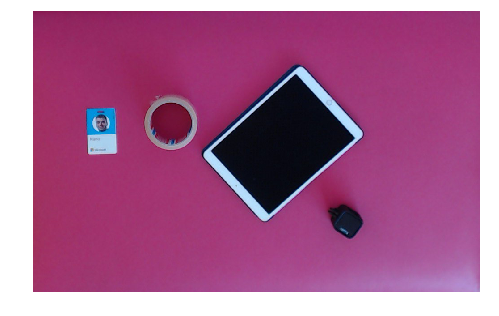

In [340]:
image = cropImage(image, startX, startY, width, height)
displayImage(image)

background = cropImage(background, startX, startY, width, height)

## Remove background

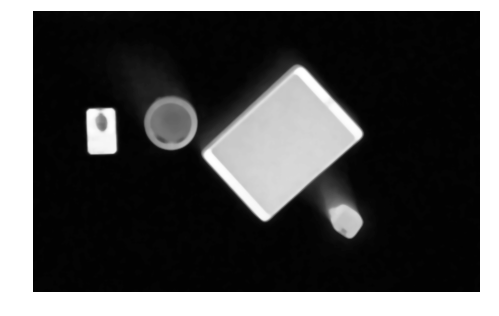

In [341]:
diff = cv2.absdiff(background, image)
mask = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
mask = cv2.medianBlur(mask, 13)
displayImage(mask)

In [342]:
#parameters
th = 20

def applyThreshold(image, mask, th):
    imask =  mask>th
    canvas = np.zeros_like(image, np.uint8)
    #canvas[:] = 255
    canvas[imask] = image[imask]
    return canvas, imask

def findThreshold(th):
    canvas, _ = applyThreshold(image, mask, th)
    displayImage(canvas)
    return th
    

w = interactive(findThreshold, th=widgets.IntSlider(min=0,max=255, step=5, value=th, continuous_update=False));
display(w)

interactive(children=(IntSlider(value=20, continuous_update=False, description='th', max=255, step=5), Output()), _dom_classes=('widget-interact',))

In [344]:
th = w.result
print(th)

50


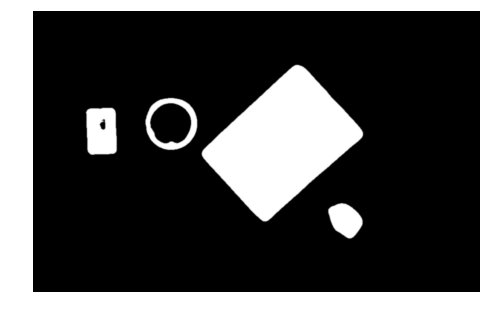

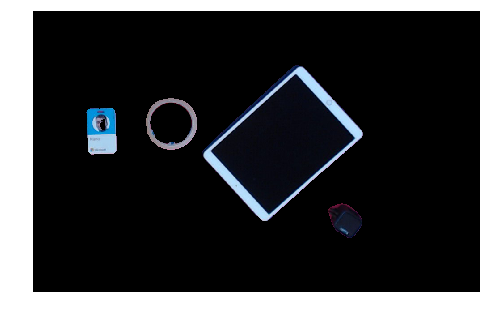

In [345]:
image, imask = applyThreshold(image, mask, th)
displayImage(imask)
displayImage(image)

ready_image = image.copy()

In [346]:
#parameters
gaussianEnabled = True
blurWindowSize = 3
minLevel = 0
maxLevel = 220

def DoGrayscaleAndBlur(image, blurWindowSize):
    # grayscale and blur
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (blurWindowSize, blurWindowSize), 0)
    return gray

def doEdgeDetection(image, minLevel, maxLevel):
    edged = cv2.Canny(image, minLevel, maxLevel)
    edged = cv2.dilate(edged, None, iterations=1)
    edged = cv2.erode(edged, None, iterations=1)
    return edged

def defParams(gaussianEnabled, blurWindowSize, minLevel, maxLevel):
    if gaussianEnabled:
        test = DoGrayscaleAndBlur(image, blurWindowSize)
    else:
        test = image
  
    edged = doEdgeDetection(test, minLevel, maxLevel)
    displayImage(edged, title="Edge Detection", figSize=(20,20))
    
    return gaussianEnabled, blurWindowSize, minLevel, maxLevel
    

w = interactive(defParams, gaussianEnabled=widgets.Checkbox(value=gaussianEnabled, description='Gaussian Blur'),
        blurWindowSize=widgets.IntSlider(min=3,max=15,step=2,value=blurWindowSize, continuous_update=False),
        minLevel=widgets.IntSlider(min=0,max=250,step=5,value=minLevel, continuous_update=False),
        maxLevel=widgets.IntSlider(min=0,max=250,step=5,value=maxLevel, continuous_update=False))

display(w)

interactive(children=(Checkbox(value=True, description='Gaussian Blur'), IntSlider(value=3, continuous_update=False, description='blurWindowSize', max=15, min=3, step=2), IntSlider(value=0, continuous_update=False, description='minLevel', max=250, step=5), IntSlider(value=220, continuous_update=False, description='maxLevel', max=250, step=5), Output()), _dom_classes=('widget-interact',))

In [347]:
gaussianEnabled, blurWindowSize, minLevel, maxLevel = w.result
print(gaussianEnabled, blurWindowSize, minLevel, maxLevel)

True 3 180 220


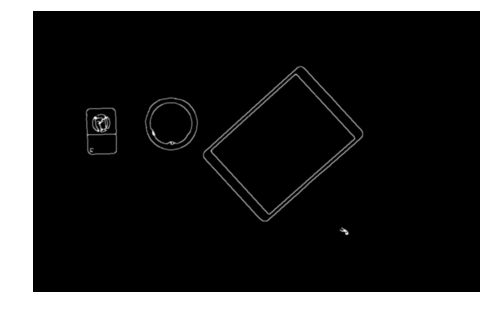

In [348]:
if gaussianEnabled:
    image = DoGrayscaleAndBlur(image, blurWindowSize)

image = doEdgeDetection(image, minLevel, maxLevel)
displayImage(image)

## Contours

In [349]:
def findMinArea(minArea):
    img = findContours(image, minArea)
    displayImage(img, figSize=(20,20))
    print('minArea = ', minArea)

def findContours(image, minArea):
    # find contours in the edge map
    cnts = cv2.findContours(image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if imutils.is_cv2() else cnts[1]

    # sort the contours from left-to-right and initialize the
    # 'pixels per metric' calibration variable
    (cnts, _) = contours.sort_contours(cnts, method='left-to-right')
    pixelsPerMetric = None

    # get areas for all contours
    areas = []
    for c in cnts:
        a = cv2.contourArea(c)
        areas.append(a)
        
    areas = np.array(areas)
    cnts = np.array(cnts)

    print("All contours:", len(cnts))
    # remove small contours
    cnts = cnts[np.where(areas >= minArea)[0]]
    print("Big contours:", len(cnts))

    # remove areas of removed contours
    areas = areas[np.where(areas >= minArea)[0]]

    # loop over the contours individually and get bounding boxes
    boxes = []
    for c in cnts:
        
        # compute the rotated bounding box of the contour
        box = cv2.minAreaRect(c)
        box = cv2.boxPoints(box) 
        box = np.array(box, dtype="int")
    
        # order the points in the contour such that they appear
        # in top-left, top-right, bottom-right, and bottom-left
        # order, then draw the outline of the rotated bounding
        # box
        box = perspective.order_points(box)
        boxes.append(box)

    boxes = np.array(boxes)
    print("Found {} bounding boxes".format(len(boxes)))

    orig = ready_image.copy()

    for b in boxes:
        cv2.drawContours(orig, [b.astype("int")], -1, (0, 255, 0), 2)
        for (x, y) in b:
            cv2.circle(orig, (int(x), int(y)), 10, (0, 0, 255), -1)
    return orig
    
interact(findMinArea, minArea=widgets.IntSlider(min=0,max=10000,step=10,value=500, continuous_update=False));

interactive(children=(IntSlider(value=500, continuous_update=False, description='minArea', max=10000, step=10), Output()), _dom_classes=('widget-interact',))

In [350]:
minArea =  500

In [351]:
knownWidth = 5.4

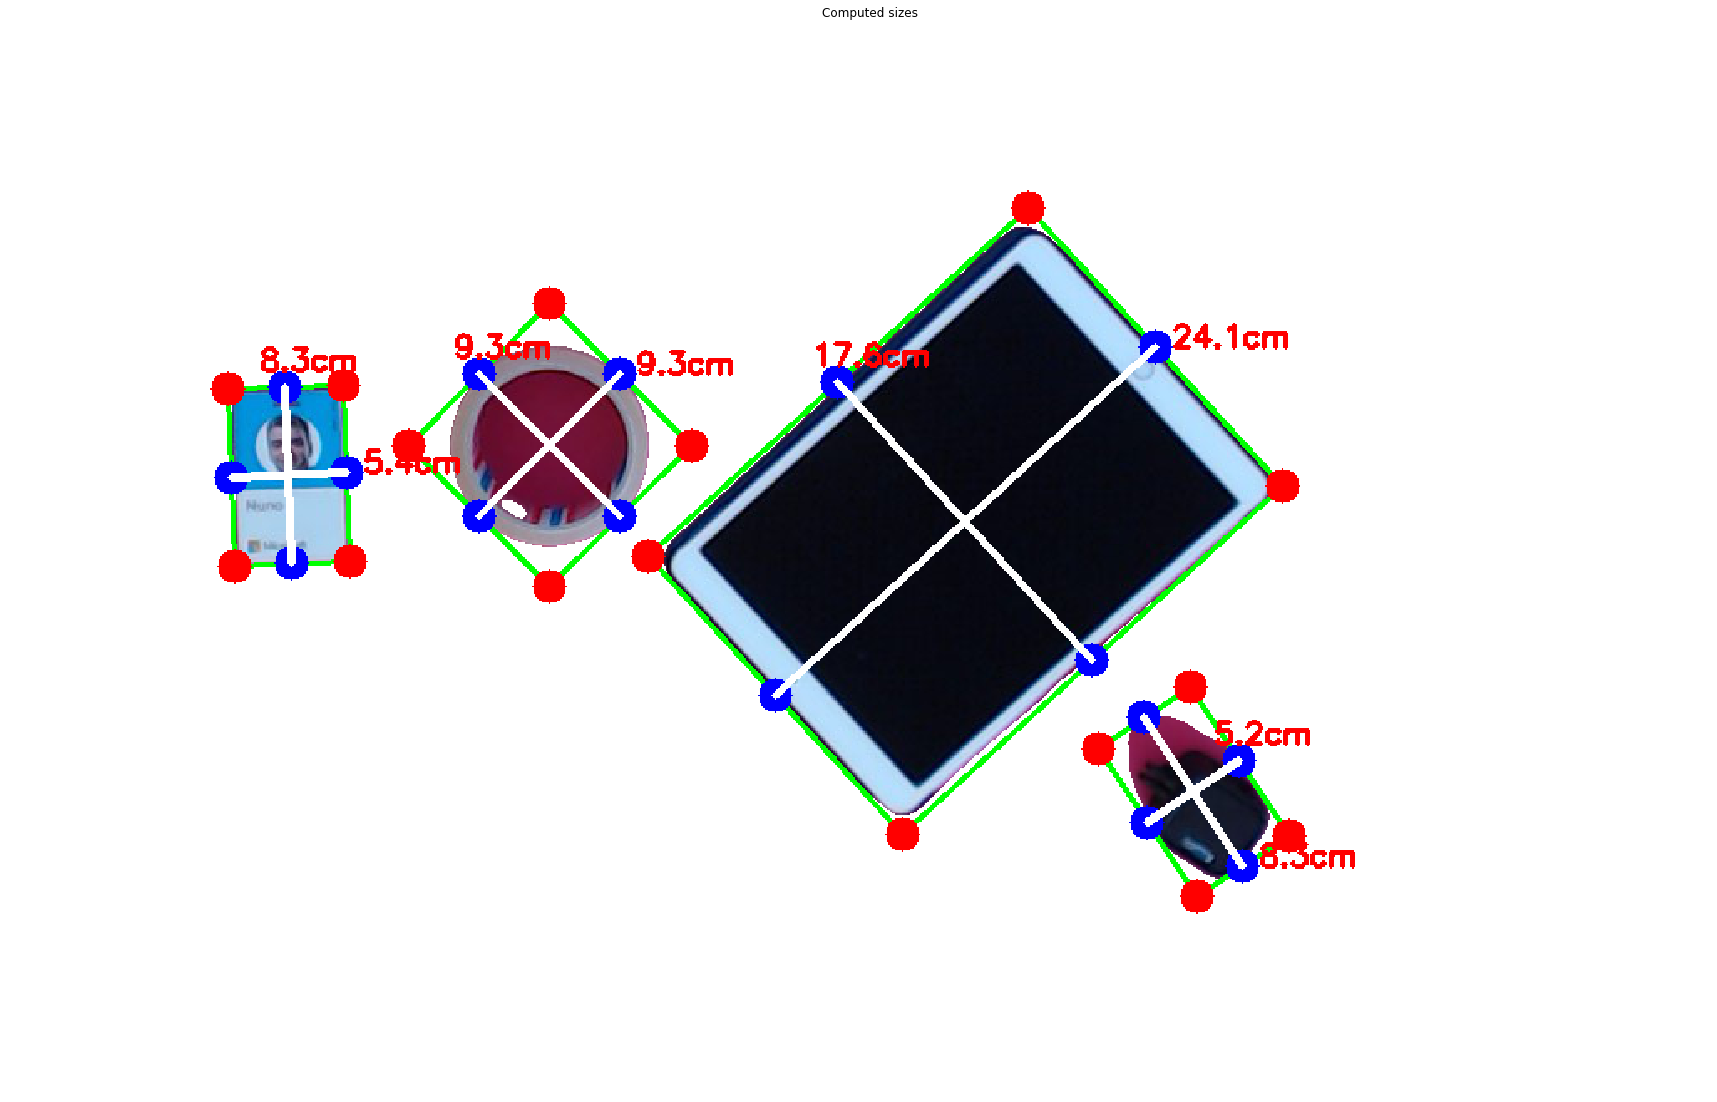

In [333]:
def midpoint(ptA, ptB):
    return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

object_sizes = []

for box in boxes:
    # unpack the ordered bounding box, then compute the midpoint
    # between the top-left and top-right coordinates, followed by
    # the midpoint between bottom-left and bottom-right coordinates
    (tl, tr, br, bl) = box
    (tltrX, tltrY) = midpoint(tl, tr)
    (blbrX, blbrY) = midpoint(bl, br)
 
    # compute the midpoint between the top-left and top-right points,
    # followed by the midpoint between the top-righ and bottom-right
    (tlblX, tlblY) = midpoint(tl, bl)
    (trbrX, trbrY) = midpoint(tr, br)
 
    # draw the midpoints on the image
    cv2.circle(orig, (int(tltrX), int(tltrY)), 10, (255,0, 0), -1)
    cv2.circle(orig, (int(blbrX), int(blbrY)), 10, (255, 0, 0), -1)
    cv2.circle(orig, (int(tlblX), int(tlblY)), 10, (255, 0, 0), -1)
    cv2.circle(orig, (int(trbrX), int(trbrY)), 10, (255, 0, 0), -1)
 
    # draw lines between the midpoints
    cv2.line(orig, (int(tltrX), int(tltrY)), (int(blbrX), int(blbrY)),(255, 255, 255), 4)
    cv2.line(orig, (int(tlblX), int(tlblY)), (int(trbrX), int(trbrY)),(255, 255, 255), 4)
    
    # compute the Euclidean distance between the midpoints
    dA = dist.euclidean((tltrX, tltrY), (blbrX, blbrY))
    dB = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))
 
    # if the pixels per metric has not been initialized, then
    # compute it as the ratio of pixels to supplied metric
    # (in this case, inches)
    if pixelsPerMetric is None:
        pixelsPerMetric = dB / knownWidth
    
    # compute the size of the object
    dimA = dA / pixelsPerMetric
    dimB = dB / pixelsPerMetric
 
    object_sizes.append([box, dimB, dimA])

    # draw the object sizes on the image
    cv2.putText(orig, "{:.1f}cm".format(dimA), (int(tltrX - 15), int(tltrY - 10)), cv2.FONT_HERSHEY_SIMPLEX,0.6, (0, 0, 255), 2)
    cv2.putText(orig, "{:.1f}cm".format(dimB), (int(trbrX + 10), int(trbrY)), cv2.FONT_HERSHEY_SIMPLEX,0.6, (0, 0, 255), 2)
        
displayImage(orig, figSize=(30,30), title='Computed sizes')

## Final Parameters Printout

In [334]:
print('startX =', startX)
print('startY =', startY)
print('width =', width)
print('height =', height)  
print("th = ",th)
print('blurWindowSize = ', blurWindowSize)
print('minLevel =', minLevel)
print('maxLevel =', maxLevel)
print('gaussianEnabled =', gaussianEnabled)
print('minArea = ', minArea)

startX = 600
startY = 450
width = 1000
height = 1080
th =  20
blurWindowSize =  3
minLevel = 0
maxLevel = 220
gaussianEnabled = True
minArea =  500
